#1. Load dataset

In [1]:
from os import path

import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from time_series_conversion import build_timeseries, convert_price

In [2]:
df = pd.read_csv("ADA.csv")
# Perform linear interpolation if there is any missing data
if df.isnull().values.any():
    df = df.interpolate() 

date = df['TIME']
df = df.drop(['TIME'], axis=1).set_index(date)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63442 entries, 30-05-21 07:30:01 to 13-06-21 07:20:01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRICE   63442 non-null  float64
dtypes: float64(1)
memory usage: 991.3+ KB


#2. Normalize data

In [3]:
total = len(df)
training_num = int(total * 0.7)
validating_num = int(total * 0.2)
testing_num = total - training_num - validating_num
print("     Total number of samples:", total)
print("  Number of training samples:", training_num)
print("Number of validating samples:", validating_num)
print("   Number of testing samples:", testing_num)

     Total number of samples: 63442
  Number of training samples: 44409
Number of validating samples: 12688
   Number of testing samples: 6345


In [4]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(df.iloc[:training_num].values)
test_set_scaled = sc.transform(df.iloc[training_num:].values)

FEATURE_NUM = len(df.columns)
print("Number of features:", FEATURE_NUM)

Number of features: 1


#3. Convert data to time series

In [5]:
TIME_STEPS = 24 # How far in the past you want to use past data as features
TARGET_TIME_STEPS = 12 # How far in the future you want to make predictions
#INP_COLS = [0, 1, 2, 3, 4]
INP_COLS = [0]
OUT_COL = 0

In [6]:
x_train, y_train = build_timeseries(mat=training_set_scaled, input_cols = INP_COLS, output_col=OUT_COL, 
                                    time_steps=TIME_STEPS, target_time_steps=TARGET_TIME_STEPS)

Use first validating_num samples for validating during training phase and
keep last testing_num samples for testing phase

In [7]:
tmp = np.concatenate((training_set_scaled[-(TIME_STEPS + TARGET_TIME_STEPS - 1):], test_set_scaled), axis=0)

x_temp, y_temp = build_timeseries(mat=tmp, input_cols = INP_COLS, output_col=OUT_COL, 
                                  time_steps=TIME_STEPS, target_time_steps=TARGET_TIME_STEPS)

x_val = x_temp[:validating_num]
y_val = y_temp[:validating_num]

x_test = x_temp[validating_num:]
y_test = y_temp[validating_num:]

In [8]:
print("     TRAIN:", x_train.shape, y_train.shape)
print("VALIDATION:", x_val.shape, y_val.shape)
print("      TEST:", x_test.shape, y_test.shape)

     TRAIN: (44374, 24, 1) (44374,)
VALIDATION: (12688, 24, 1) (12688,)
      TEST: (6345, 24, 1) (6345,)


#4. Build an LSTM model and fit the model

In [9]:
inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))
hidden = LSTM(64, dropout=0.01, recurrent_dropout=0.05)(inputs)
hidden = Dense(32, activation='relu')(hidden)
hidden = Dropout(0.1)(hidden) 
outputs = Dense(1)(hidden)
model = Model(inputs, outputs)

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Declare callback functions
check = tf.keras.callbacks.ModelCheckpoint("my_model.h5", monitor='val_loss',
                                           save_best_only=True)
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=20)

# Load pre-trained model
if path.exists("my_model.h5"):
  model = keras.models.load_model("my_model.h5")

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________


In [10]:
NUM_EPOCHS = 500

# Fitting the RNN to the Training set
history = model.fit(
    x=x_train, 
    y=y_train,
    epochs=NUM_EPOCHS,
    batch_size=64,
    validation_data=(x_val, y_val), 
    callbacks=[early_stopping_monitor, check]
)

Epoch 1/500
694/694 [==============================] - 26s 35ms/step - loss: 3.5522e-04 - val_loss: 3.9456e-04
Epoch 2/500
694/694 [==============================] - 24s 35ms/step - loss: 3.5832e-04 - val_loss: 6.2353e-05
Epoch 3/500
694/694 [==============================] - 24s 34ms/step - loss: 3.5887e-04 - val_loss: 2.5169e-04
Epoch 4/500
694/694 [==============================] - 24s 35ms/step - loss: 3.5130e-04 - val_loss: 1.8038e-04
Epoch 5/500
694/694 [==============================] - 24s 34ms/step - loss: 3.5490e-04 - val_loss: 1.5940e-04
Epoch 6/500
694/694 [==============================] - 24s 34ms/step - loss: 3.5925e-04 - val_loss: 1.7322e-04
Epoch 7/500
694/694 [==============================] - 24s 34ms/step - loss: 3.5230e-04 - val_loss: 8.6109e-05
Epoch 8/500
694/694 [==============================] - 24s 34ms/step - loss: 3.5203e-04 - val_loss: 6.5440e-05
Epoch 9/500
694/694 [==============================] - 24s 35ms/step - loss: 3.5134e-04 - val_loss: 4.0145e-05
E

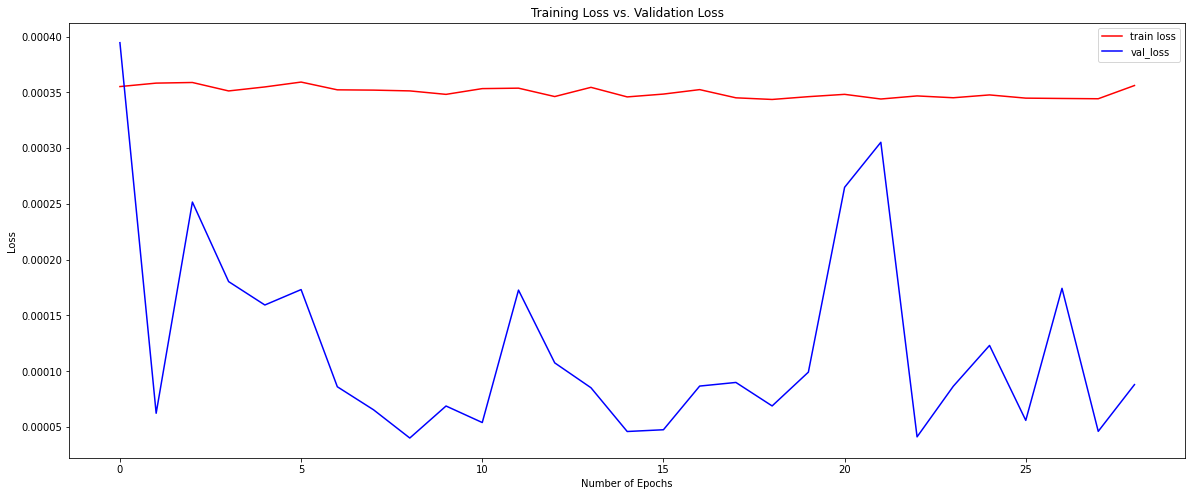

In [11]:
# Visualising the results
plt.figure(1,figsize=(20, 8))
plt.plot(history.history['loss'], color = 'red')
plt.plot(history.history['val_loss'], color = 'blue')
plt.title('Training Loss vs. Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend(['train loss', 'val_loss'], loc='upper right')
plt.show()

In [12]:
def plot_price_prediction(date, real, pred):
    plt.figure(1,figsize=(12, 12))
    plt.plot(date, real, color = 'red', label = 'Real Price')
    plt.plot(date, pred, color = 'blue', label = 'Predicted Price')
    
    plt.xticks(np.arange(0, len(date), len(date)//7), rotation=45)

    plt.title('Cryptocurrency Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Crypto Price Price')
    plt.legend()
    plt.show()

#5. Price prediction and Evaluation of LSTM

##Validating data

In [13]:
pred_val = model.predict(x_val).flatten()
predicted_price_val = convert_price(pred_val, sc, FEATURE_NUM, OUT_COL)
real_price_val = df.iloc[training_num:training_num+validating_num, OUT_COL]

##Testing data

In [14]:
N_ITER = 500

# Repeat predicting testing data N_ITER times
pred_do = np.stack([model(x_test, training=True) for _ in range(N_ITER)])
pred_do = pred_do.reshape((N_ITER, testing_num))

# Convert these predictions into price
for row in range(pred_do.shape[0]):
  pred_do[row, :] = convert_price(pred_do[row, :], sc, FEATURE_NUM, OUT_COL)

# Calculate mean price as the prediction representative and the uncertainty for each sample
predicted_price = pred_do.mean(axis=0)
model_uncertainty = pred_do.std(axis=0)

# Use the model to predict the price without using Monte Carlo Dropout
pred_no_MC = model.predict(x_test).flatten()
pred_no_MC = convert_price(pred_no_MC, sc, FEATURE_NUM, OUT_COL)

# Calculate real price of testing data
real_price = df.iloc[-testing_num:, OUT_COL]

print("Average difference between 2 predictions =", mean_absolute_error(pred_no_MC, predicted_price))

Average difference between 2 predictions = 0.0005236331180935754


In [15]:
inherent_noise = mean_squared_error(real_price_val, predicted_price_val)
print("Inherent noise, which captures the uncertainty in data generation process, is", inherent_noise)
print()

print("When using MC Dropout:")

print("1. Root Mean Squared Error =", math.sqrt(mean_squared_error(real_price, predicted_price)))
print("2. Mean Absolute Error =", mean_absolute_error(real_price, predicted_price))
print()

print("When not using MC Dropout:")
print("1. Root Mean Squared Error =", math.sqrt(mean_squared_error(real_price, pred_no_MC)))
print("2. Mean Absolute Error =", mean_absolute_error(real_price, pred_no_MC))

Inherent noise, which captures the uncertainty in data generation process, is 1.9938741986288994e-05

When using MC Dropout:
1. Root Mean Squared Error = 0.002697687919309132
2. Mean Absolute Error = 0.002048127227314258

When not using MC Dropout:
1. Root Mean Squared Error = 0.002623979160490863
2. Mean Absolute Error = 0.0019831135937496366


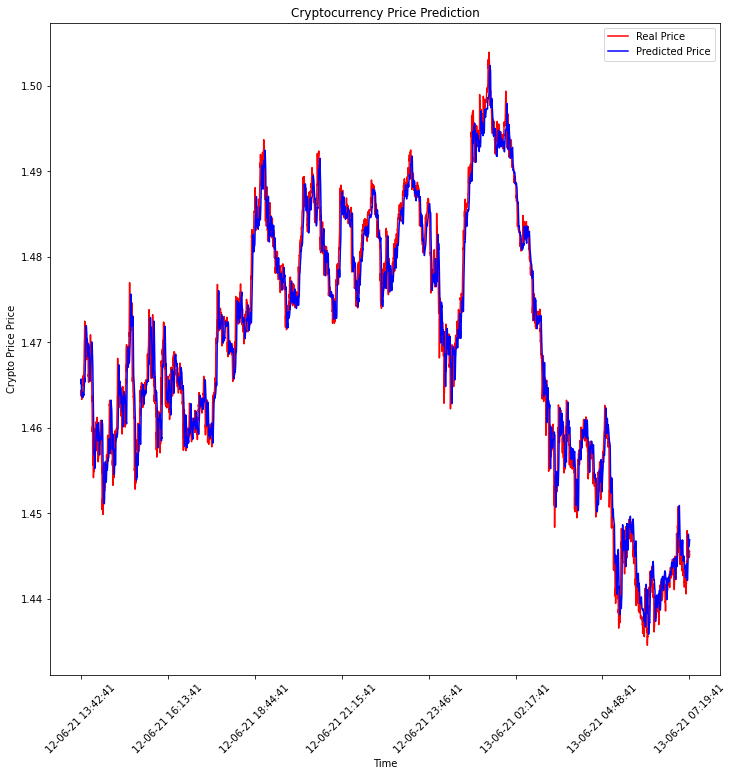

In [16]:
plot_price_prediction(date[-testing_num:], real_price, pred_no_MC)

##Confidence level of trend prediction:


rRMSE of LSTM = 0.18
MAPE of LSTM = 0.05
Accuracy of trend prediction by LSTM = 50.01%

Highest confidence level = 52.35%


(array([3.320e+03, 1.956e+03, 7.920e+02, 2.080e+02, 5.100e+01, 1.200e+01,
        4.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([0.5000019 , 0.50235076, 0.50469962, 0.50704848, 0.50939734,
        0.5117462 , 0.51409506, 0.51644392, 0.51879278, 0.52114163,
        0.52349049]),
 <a list of 10 Patch objects>)

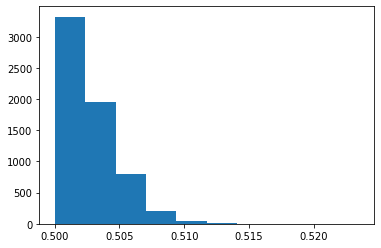

In [17]:
standard_error = (model_uncertainty + inherent_noise) ** 0.5

current = x_test[:, -1].flatten()
current_price = convert_price(current, sc, FEATURE_NUM, OUT_COL) # Corresponding current price

diff = np.abs(predicted_price - current_price)
z_score = diff / standard_error
probs = st.norm.cdf(z_score) # probs = estimated probability of correct trend prediction

print('rRMSE of LSTM =', np.round(100 * math.sqrt(mean_squared_error(real_price, predicted_price)) / real_price.mean(), 2))
print("MAPE of LSTM =", np.round(100 * np.mean(diff / np.abs(current_price)), 2))

# Calculate accuracy of trend prediction
correct_trend_predictions_lstm = 0
for i in range(len(real_price)):
  if ((real_price[i] - current_price[i]) * (predicted_price[i] - current_price[i]) > 0): 
    correct_trend_predictions_lstm += 1 # Correct trend prediction
print("Accuracy of trend prediction by LSTM = {}%".format(np.round(correct_trend_predictions_lstm / len(real_price) * 100, 2)))
print()

# Plot distribution of confidence level
print("Highest confidence level = {}%".format(np.round(probs.max() * 100, 2)))
plt.hist(probs)

In [18]:
correct_trend_predictions_lstm = 0
for i in range(len(real_price)):
  if ((real_price[i] - current_price[i]) * (predicted_price[i] - current_price[i]) > 0): 
    correct_trend_predictions_lstm += 1 # Correct trend prediction

print("Accuracy of trend prediction by LSTM = {}%".format(np.round(correct_trend_predictions_lstm / len(real_price) * 100, 2)))

Accuracy of trend prediction by LSTM = 50.01%


# 6. Other Machine Learning Methods

Use first training_num + validating_num samples for training and
keep last testing_num samples for testing

In [19]:
training_set_ml = df.iloc[:training_num + validating_num].values
testing_set_ml = df.iloc[-(testing_num + TIME_STEPS + TARGET_TIME_STEPS - 1):].values

# Create a training set
x_train_ml, y_train_ml = build_timeseries(mat=training_set_ml, input_cols=INP_COLS, output_col=OUT_COL, 
                                          time_steps=TIME_STEPS, target_time_steps=TARGET_TIME_STEPS)
x_train_ml = x_train_ml.reshape((x_train_ml.shape[0], x_train_ml.shape[1] * x_train_ml.shape[2]))

# Create a testing set
x_test_ml, y_test_ml = build_timeseries(mat=testing_set_ml, input_cols=INP_COLS, output_col=OUT_COL, 
                                        time_steps=TIME_STEPS, target_time_steps=TARGET_TIME_STEPS)
x_test_ml = x_test_ml.reshape((x_test_ml.shape[0], x_test_ml.shape[1] * x_test_ml.shape[2]))

current_price_ml = x_test_ml[:, -1]

Train ML models

In [20]:
# Train ML models
models = {'Linear Regresssion': LinearRegression(), 
          'Decision Tree': DecisionTreeRegressor(max_depth=5, min_samples_leaf=0.1, min_samples_split=0.1),
          'SVM': SVR(C=100),
          'Random Forest': RandomForestRegressor(n_estimators=100, n_jobs=-1),
          'Stochastic Gradient Boosting': GradientBoostingRegressor(learning_rate=0.1, max_depth=6, subsample=0.7)}
for key, model in models.items():
  model.fit(x_train_ml, y_train_ml)
  pred = model.predict(x_test_ml)
  diff_ml = np.abs(pred - current_price_ml)
  print('rRMSE of {} = {}'.format(key, np.round(100 * math.sqrt(mean_squared_error(y_test_ml, pred)) / y_test_ml.mean(), 2)))
  print("MAPE of {} = {}".format(key, np.round(100 * np.mean(diff_ml / np.abs(current_price_ml)), 2)))

  correct_trend_predictions_ml = 0
  for i in range(len(y_test_ml)):
    if ((y_test_ml[i] - current_price_ml[i]) * (pred[i] - current_price_ml[i]) > 0): 
      correct_trend_predictions_ml += 1 # Correct trend prediction

  print("Accuracy of trend prediction by {} = {}%".format(key, np.round(correct_trend_predictions_ml / len(y_test_ml) * 100, 2)))
  print()


rRMSE of Linear Regresssion = 0.17
MAPE of Linear Regresssion = 0.01
Accuracy of trend prediction by Linear Regresssion = 49.98%

rRMSE of Decision Tree = 2.48
MAPE of Decision Tree = 2.27
Accuracy of trend prediction by Decision Tree = 46.64%

rRMSE of SVM = 5.13
MAPE of SVM = 5.13
Accuracy of trend prediction by SVM = 50.42%

rRMSE of Random Forest = 0.22
MAPE of Random Forest = 0.11
Accuracy of trend prediction by Random Forest = 49.14%

rRMSE of Stochastic Gradient Boosting = 0.18
MAPE of Stochastic Gradient Boosting = 0.05
Accuracy of trend prediction by Stochastic Gradient Boosting = 49.99%



Uncomment the following cell is to calculate confidence level of each prediction by Linear Regression 

Highest confidence level = 58.08%


(array([2.523e+03, 1.892e+03, 9.960e+02, 5.590e+02, 2.340e+02, 9.500e+01,
        3.200e+01, 9.000e+00, 4.000e+00, 1.000e+00]),
 array([0.50000429, 0.50808873, 0.51617318, 0.52425762, 0.53234207,
        0.54042651, 0.54851096, 0.55659541, 0.56467985, 0.5727643 ,
        0.58084874]),
 <a list of 10 Patch objects>)

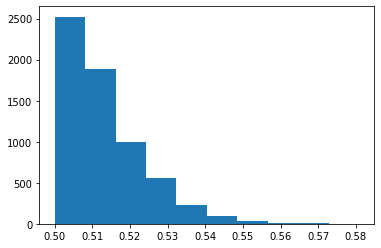

In [21]:
''' # Delete this line to uncomment

n = len(x_train_ml) # n = number of training samples
dof = n - TIME_STEPS - 1 # dof = Degree of Freedom

# Train data using Linear Regression
reg = LinearRegression()
reg.fit(x_train_ml, y_train_ml)
pred_lr = reg.predict(x_test_ml)

# Calculate Sxx
x_mean = x_train_ml.mean(axis=0)
x_mean = x_mean.reshape((TIME_STEPS, 1))
S = np.zeros((TIME_STEPS, TIME_STEPS)) # S = S_xx
for x in x_train_ml:
    d = x.reshape((TIME_STEPS, 1)) - x_mean
    S += np.matmul(d, d.T)

# Calculate estimated standard deviation
pred_train = reg.predict(x_train_ml)
sum = np.sum((y_train_ml - pred_train) ** 2) # sum = residual sum of squares
sd = np.sqrt(sum / dof) # sd = sigma, ie, estimated standard deviation

# Calculate standard error
standard_error_lr = np.zeros(len(y_test_ml))
for idx in range(len(standard_error_lr)):
    d = x_test_ml[idx].reshape((TIME_STEPS, 1)) - x_mean
    inversed_S = np.linalg.inv(S)
    standard_error_lr[idx] = sd * np.sqrt(1 + 1/n + d.T @ inversed_S @ d)

# Calculate confidence level of prediction
diff_lr = np.abs(pred_lr - current_price_ml)
t_score = diff_lr / standard_error_lr
probs_lr = st.t.cdf(t_score, dof) # probs_lr = estimated probability of correct trend prediction

# Plot distribution of confidence level
print("Highest confidence level = {}%".format(np.round(probs_lr.max() * 100, 2)))
plt.hist(probs_lr)